### Multivariate & Multi step forecasting

#### Regression models
First, we assume that the model is a reasonable approximation to reality; 
that is, the relationship between the forecast variable and the predictor variables satisfies this linear equation.
- they have mean zero; otherwise the forecasts will be systematically biased.
- they are not autocorrelated; otherwise the forecasts will be inefficient, as there is more information in the data that can be exploited.
- they are unrelated to the predictor variables; otherwise there would be more information that should be included in the systematic part of the model.

It is also useful to have the errors being normally distributed with a constant variance σ2 in order to easily produce prediction intervals.

Another important assumption in the linear regression model is that each predictor x is not a random variable. If we were performing a controlled experiment in a laboratory, we could control the values of each x (so they would not be random) and observe the resulting values of y. With observational data (including most data in business and economics), it is not possible to control the value of x, we simply observe it. Hence we make this an assumption.

### Multivariate Multi-step Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras

In [202]:
from numpy import unique
from numpy import nan
from numpy import array
from numpy import savetxt
from pandas import read_csv
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('mv_port_processed_clusters.csv')

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (16,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['Project Number'] = df['Project Number'].astype('str') 

In [4]:
df = df[df['Project Number'] != 'fw0labor00in'] 
df = df[df['Project Number'] != 'fw0labor0out'] 

In [5]:
df.isnull().sum()

Project Name                           0
Health and Safety Status               0
Project Status                         0
SalesCloudClientNo                     0
Contract Type Name                     0
Ultimate Customer AUS Market Sector    0
Division Short Name                    0
location_2                             0
location_4                             0
Region                                 0
Country                                0
Proj_CVP                               0
Proj_Serv_Offering                     0
CVP Description                        0
primary_client_industry                0
Sales Cloud Opportunity Number         0
Funding Amount - ITC (Snapshot)        0
Backlog NR                             0
Actual Direct Labor Cost - MTD         0
Actual Non-Labor Cost - MTD            0
Actual Gross Revenue - MTD             0
Actual Net Revenue - MTD               0
EBITA - MTD                            0
Forecast Direct Labor Cost - ITC       0
Forecast Net Rev

In [6]:
print(df.columns.tolist())

['Project Name', 'Health and Safety Status', 'Project Status', 'SalesCloudClientNo', 'Contract Type Name', 'Ultimate Customer AUS Market Sector', 'Division Short Name', 'location_2', 'location_4', 'Region', 'Country', 'Proj_CVP', 'Proj_Serv_Offering', 'CVP Description', 'primary_client_industry', 'Sales Cloud Opportunity Number', 'Funding Amount - ITC (Snapshot)', 'Backlog NR', 'Actual Direct Labor Cost - MTD', 'Actual Non-Labor Cost - MTD', 'Actual Gross Revenue - MTD', 'Actual Net Revenue - MTD', 'EBITA - MTD', 'Forecast Direct Labor Cost - ITC', 'Forecast Net Revenue - ITC', 'Order Intake (NR) - MTD', 'bookings_jtd', 'interest_current', 'interest_jtd', 'interest_ytd', 'multiplier_budget', 'multiplier_current', 'multiplier_target', 'overhead_current', 'overhead_rate', 'revenue_type', 'AUS Mkt Sector Aggregate', 'Baseline NR', 'Break Even Multiplier - Project', 'Organization Size', 'Risk Profile', 'riskrating_project', 'ActualNR_sum', 'Projectduration', 'Date', 'Project Number', 'Comp

In [6]:
''' lets make a transpose, where each project is a column, and the entries are the actual net revenue, rows are time steps'''
df_sub = df[['Date', 'Project Number', 'Actual Net Revenue - MTD']]

In [10]:
df_pivot=df_sub.assign(d=df_sub.Date, t=df_sub['Project Number']) \
            .pivot_table(index='d', columns='t', values='Actual Net Revenue - MTD', fill_value=0)
            #.rename_axis(None, 1)

In [8]:
df_pivot

t,000221760018,000221760021,000221760022,000221760050,000221762018,000231710001,000275410000,00041053mp81,000430560000,000771780000,...,zz000yyyis10,zz000yyylc10,zz000yyynt10,zz000zzzad20,zz000zzzae20,zz000zzzfs20,zz000zzzim20,zz000zzzis20,zz000zzzlc20,zz000zzznt20
d,,,,,,,,,,,,,,,,,,,,,
201601,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
201602,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
201603,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
201604,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
201605,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202011,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
202012,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
202101,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


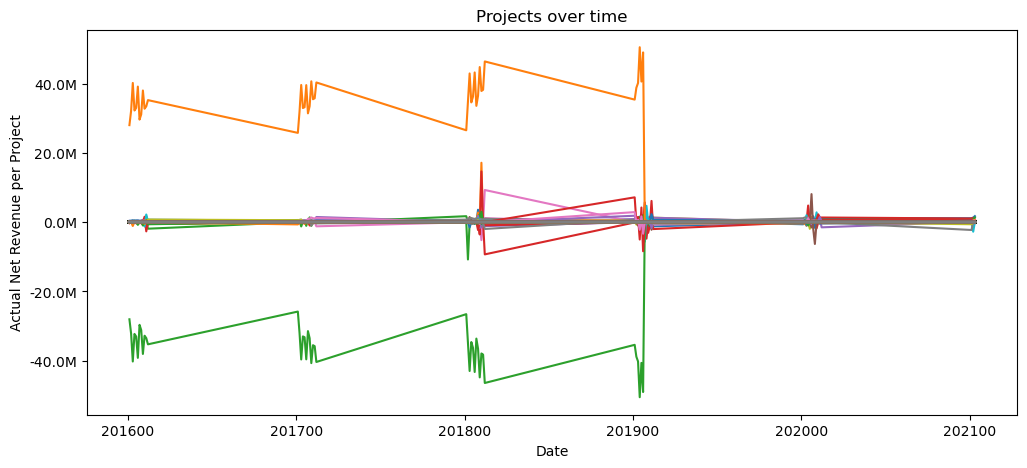

In [94]:
#don't touch

''' import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


millions_formatter = FuncFormatter(millions)

ax=df_pivot.plot(figsize=(12,5));
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('Actual Net Revenue per Project')
ax.legend().set_visible(False)
#plt.legend().remove()
plt.title('Projects over time');
plt.show() '''

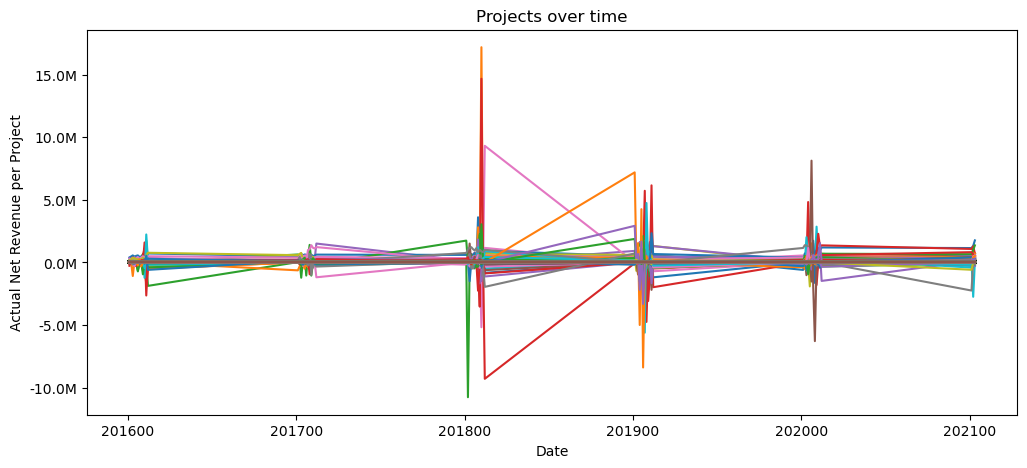

In [22]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


millions_formatter = FuncFormatter(millions)

ax=df_pivot.plot(figsize=(12,5));
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('Actual Net Revenue per Project')
ax.legend().set_visible(False)
#plt.legend().remove()
plt.title('Projects over time');
plt.show()

In [192]:
scaler = StandardScaler()
scaler.fit(df_pivot)
numeric_scale = scaler.transform(df_pivot)

In [193]:
train_df,test_df = numeric_scale[:-24], numeric_scale[-24:] 

In [194]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
    return np.array(X), np.array(y)

In [195]:
n_past = 12
n_future = 13
n_features = 78126

In [196]:
X_train, y_train = split_series(train_df, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
#y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))


X_test, y_test = split_series(test_df, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
#y_test = y_test.reshape((y_test.reshape(1, 10, 78128)))

In [197]:
X_train.shape

(1, 12, 78126)

In [198]:
n_past = 12
n_future = 12
n_features = 78126

In [41]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features, activation = 'softmax'))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 12, 78126)]  0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 100), (None, 31290800    input_3[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 12, 100)      0           lstm_6[0][0]                     
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 12, 100)      80400       repeat_vector_2[0][0]            
                                                                 lstm_6[0][1]               

In [199]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 78126)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 12, 100), (N 31290800    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 80400       lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 12, 100)      0           lstm_1[0][0]                     
______________________________________________________________________________________________

In [203]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])


In [204]:
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber()) #optimizer='rmsprop', loss='categorical_crossentropy'
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [205]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [47]:
pred_e2d2

array([[[ 0.00317447,  0.00631687, -0.00240729, ...,  0.00398825,
          0.00131678, -0.00629851],
        [-0.00010729,  0.00401155, -0.00607172, ...,  0.00343438,
          0.00202794, -0.0047219 ],
        [-0.00225837,  0.00258883, -0.00856281, ...,  0.00314334,
          0.00202432, -0.00362913],
        ...,
        [-0.00428767,  0.00255392, -0.01134944, ...,  0.00374282,
         -0.00043188, -0.00246077],
        [-0.00398639,  0.00302114, -0.01114703, ...,  0.00398537,
         -0.00063792, -0.00248741],
        [-0.00368488,  0.00347472, -0.01094962, ...,  0.00423243,
         -0.00082433, -0.00248387]]], dtype=float32)

In [206]:
pred1_e1d1=scaler.inverse_transform(pred_e1d1)
pred2_e2d2=scaler.inverse_transform(pred_e2d2)

y_train_inverse =scaler.inverse_transform(y_train)
y_test_inverse =scaler.inverse_transform(y_test)

In [50]:
mse = ((pred1_e1d1 - y_test_inverse) ** 2).mean()
import numpy as np
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The normalized Root Mean Squared Error of our forecasts is {}'.format( (round(np.sqrt(mse), 2))/ ((y_test_inverse.max() - y_test_inverse.min())* 100)))

The Mean Squared Error of our forecasts is 325566812.34
The Root Mean Squared Error of our forecasts is 18043.47
The normalized Root Mean Squared Error of our forecasts is 1.2521084671443862e-05


In [51]:
mse = ((pred2_e2d2 - y_test_inverse) ** 2).mean()
import numpy as np
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The normalized Root Mean Squared Error of our forecasts is {}'.format( (round(np.sqrt(mse), 2))/ ((y_test_inverse.max() - y_test_inverse.min())* 100)))

The Mean Squared Error of our forecasts is 324759130.63
The Root Mean Squared Error of our forecasts is 18021.07
The normalized Root Mean Squared Error of our forecasts is 1.2505540416561603e-05


In [33]:
0.0000125055 * 100

0.00125055

In [216]:
pred2_e2d2shaped = pred2_e2d2.reshape( 12,78126)

In [217]:
predictionslstm = pd.DataFrame(pred2_e2d2shaped)

,0,1,2,3,4,5,6,7,8,9,...,78116,78117,78118,78119,78120,78121,78122,78123,78124,78125
0,133.875275,199.950592,30.522287,-2.448333,141.536499,1035.696533,0.005873,0.001743,3016.861572,490.992004,...,-0.002697,-0.004460,-0.006875,-0.003740,-0.002577,-0.009519,-0.002967,-0.012557,-0.000425,-0.001290
1,135.770782,196.290909,29.911505,-2.526202,141.354523,1033.349976,0.003720,0.001645,3005.785889,488.003632,...,-0.001558,-0.004582,-0.005146,-0.000689,-0.003625,-0.009069,-0.002767,-0.010409,0.001545,-0.002193
2,136.939102,194.571625,29.491751,-2.558484,141.247177,1031.783203,0.002216,0.002028,2995.832520,486.096954,...,-0.000864,-0.004535,-0.003765,0.001459,-0.004065,-0.008692,-0.002347,-0.008129,0.003038,-0.002829
3,137.618988,193.935928,29.236923,-2.561464,141.230423,1030.868530,0.001231,0.002605,2987.577637,485.000092,...,-0.000572,-0.004478,-0.002646,0.002827,-0.004060,-0.008377,-0.001806,-0.005994,0.004140,-0.003170
4,137.999161,193.792511,29.111691,-2.547219,141.291718,1030.671143,0.000611,0.003220,2981.712891,484.476715,...,-0.000536,-0.004464,-0.001744,0.003590,-0.003772,-0.008088,-0.001233,-0.004157,0.004912,-0.003229
5,138.203506,193.803207,29.081177,-2.524287,141.404312,1031.187866,0.000236,0.003797,2978.387207,484.336243,...,-0.000627,-0.004509,-0.001034,0.003924,-0.003320,-0.007805,-0.000689,-0.002670,0.005403,-0.003054
6,138.304260,193.796707,29.114672,-2.498446,141.541611,1032.349365,0.000020,0.004300,2977.377197,484.440033,...,-0.000756,-0.004611,-0.000489,0.003975,-0.002789,-0.007519,-0.000206,-0.001525,0.005660,-0.002709
7,138.340347,193.699432,29.187672,-2.473381,141.682449,1034.053467,-0.000098,0.004717,2978.281250,484.694794,...,-0.000872,-0.004756,-0.000088,0.003854,-0.002235,-0.007229,0.000200,-0.000679,0.005730,-0.002260
8,138.331314,193.491226,29.282124,-2.451247,141.812408,1036.188110,-0.000155,0.005049,2980.656982,485.041107,...,-0.000947,-0.004929,0.000194,0.003638,-0.001691,-0.006940,0.000526,-0.000080,0.005659,-0.001764
9,138.286346,193.179596,29.385555,-2.433107,141.923264,1038.642334,-0.000177,0.005305,2984.093506,485.441650,...,-0.000974,-0.005115,0.000377,0.003380,-0.001177,-0.006656,0.000776,0.000321,0.005487,-0.001263


### VARMAX

In [7]:
df_sub = df[['Date', 'Project Number', 'Actual Net Revenue - MTD']]

In [8]:
df_pivot=df_sub.assign(d=df_sub.Date, t=df_sub['Project Number']) \
            .pivot_table(index='d', columns='t', values='Actual Net Revenue - MTD', fill_value=0)
            #.rename_axis(None, 1)

In [9]:
df_pivot

t,000221760018,000221760021,000221760022,000221760050,000221762018,000231710001,000275410000,00041053mp81,000430560000,000771780000,...,zz000yyyis10,zz000yyylc10,zz000yyynt10,zz000zzzad20,zz000zzzae20,zz000zzzfs20,zz000zzzim20,zz000zzzis20,zz000zzzlc20,zz000zzznt20
d,,,,,,,,,,,,,,,,,,,,,
201601,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
201602,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
201603,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
201604,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
201605,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202011,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
202012,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
202101,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
from scipy.stats import boxcox
from matplotlib import pyplot


#sub=df_sub.groupby(['Date'])['Actual Net Revenue - MTD'].sum().reset_index()

#df_pivot, lam = boxcox(df_pivot)

#sub['Actual Net Revenue - MTD'] = boxcox(sub['Actual Net Revenue - MTD'], lmbda=-1)
#print('Lambda: %f' % lam)
#pyplot.figure(1)
# line plot


In [29]:
df_sub2 = df.groupby(['Date'])['seasonality_month', 'Month', 'ADL_shifted', 'ANR_shifted', 'ANR_previous_year'].max().reset_index()
df_sub2=df_sub2.set_index('Date')

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [30]:
X = df_sub2
Y = df_pivot

df_forecast = []
scaler = StandardScaler()
scaler.fit(df_pivot)

StandardScaler()

In [31]:
dataset = Y.iloc[:, 3:4]
dataset.columns.values

array(['000221760050'], dtype=object)

In [32]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

In [33]:
from statsmodels.tsa.stattools import adfuller
from math import sqrt

from scipy.stats import boxcox
from matplotlib import pyplot

df_forecast = []

for i in range(1,78126):
    diff = []
    b = i-1
    data = Y.iloc[:, b:i]
    dataset = data.values
    column = data.columns.values
    dataset = dataset.reshape(63,)
    dataset = np.where(dataset <= 0, 0.1, dataset) 
    if dataset.sum() > 7: 
        dataset = boxcox(dataset, lmbda=0.078)
        diff = difference(dataset, 1)
        result = adfuller(diff)
        diff.append(result[1])
        diff.append(column)
        df_forecast.append(diff)      

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountere

In [34]:
df_forecast = pd.DataFrame.from_records(df_forecast)

In [35]:
import re

df_forecast[63]=df_forecast[63].str[0]
df_forecast=df_forecast.set_index(63)
df_forecast

In [ ]:
import numpy as np
from numpy import inf

In [39]:
datedf= df.groupby('Date')["Month"].count().reset_index()
datedf.pop("Month")

0      2146
1      2252
2      2351
3      2438
4      2558
      ...  
58    48080
59    49329
60    50659
61    52503
62    54050
Name: Month, Length: 63, dtype: int64

In [68]:
#Now we only accept time series where the 
suby =df_forecast[df_forecast[62] < 0.05]
suby=suby.T
suby = pd.concat([datedf, suby], axis=1)
suby = suby.set_index('Date')

In [69]:
suby.isna().sum()

000221760018    0
000221760021    0
000221760022    0
000221760050    0
000221762018    0
               ..
yc2351351680    0
yc2351351825    0
yc3351351664    0
yc3351351801    0
yc3351351828    0
Length: 39460, dtype: int64

In [70]:
suby

,000221760018,000221760021,000221760022,000221760050,000221762018,000231710001,000430560000,000771780000,000919050000,000919982019,...,wy0023410002,wy0027570001,wy0027980001,yc000yyyip10,yc2351351402,yc2351351680,yc2351351825,yc3351351664,yc3351351801,yc3351351828
Date,,,,,,,,,,,,,,,,,,,,,
201601,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.419053e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
201602,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-6.274753e-01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
201603,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-2.341880e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
201604,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.558762e+00,1.642849e+01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
201605,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.197535e+00,-1.082738e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202011,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
202012,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
202101,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00


In [71]:
suby.replace([np.inf, -np.inf], np.nan, inplace=True)

In [72]:
suby.dropna(how="all", inplace=True)

In [73]:
sub=suby.iloc[:, 20000:20020]

In [74]:
y_train = sub.iloc[:51]
X_train = X.iloc[:51]

y_test = sub.iloc[51:]
X_test = X.iloc[51:]

In [81]:
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency #trend=[1,1,3,12]

data = y_train
data_exog = X_train

# fit model
model = VARMAX(data, exog=data_exog, order=(1, 1), enforce_stationarity=False, enforce_invertibility=False , error_cov_type='diagonal')

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [82]:
model_fit = model.fit(disp=False)

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [100]:
# make prediction
data_exog2 = X_test

start_index = len(y_train)
end_index = start_index + len(y_test) -1

yhat2 = model_fit.predict(start=start_index, end=end_index, exog=data_exog2)

#yhat = model_fit.forecast(exog=data_exog2)
print(yhat2)

    30040548  30040549  30040550  30040552  30040553  30040556  30040558  \
51 -3.942274 -0.045861  0.062724 -0.973048 -0.537693  7.740023 -1.088380   
52  3.375503 -3.650830 -3.320666 -5.510150  3.329481 -0.149485 -0.885155   
53  1.927300  3.998879  3.436932  7.768964  0.498130  3.983517 -0.863324   
54 -1.485720  0.491532  0.710934 -1.541587  0.874511 -0.897919 -1.148080   
55 -0.227555  2.853076  2.606263  4.209137  0.427706  3.341123  1.170234   
56  1.716891 -1.736722 -1.450640 -3.737793  2.350822 -1.960503  0.966265   
57  2.830214  1.825665  1.527147  3.910049  1.965164  3.659374  1.668758   
58  0.890718 -1.382884 -1.182295 -2.740799  2.250347  2.286405 -1.902720   
59  1.979749  2.946039  2.568027  5.412109  1.205864  3.009121 -0.456806   
60  0.459680  0.762487  0.850602 -0.208507  1.503990 -1.211001 -1.075600   
61 -1.144187  3.287776  2.970834  5.131918 -0.353597  4.386444 -1.833933   
62 -2.210039  0.623068  0.754350 -0.683396  0.028244  0.890682 -3.035178   

    3004055

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


In [113]:
model_fit.summary()

Dep. Variable:,"['30040548', '30040549', '30040550', '30040552', '30040553', '30040556', '30040558', '30040559', '30040560', '30040561', '30040563', '30040566', '30040567', '30040573', '30040575', '30040580', '30040582', '30040583', '30040584', '30040585']",No. Observations:,51
Model:,"VARMAX(1,1)",Log Likelihood,-1966.917
,+ intercept,AIC,5813.834
Date:,"Tue, 22 Jun 2021",BIC,7629.750
Time:,13:16:32,HQIC,6507.749
Sample:,0,,
,- 51,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.47, 13.83, 13.43, 12.75, 0.15, 5.54, 1.07, 0.02, 0.71, 12.15, 0.08, 12.05, 0.09, 7.82, 14.24, 10.17, 0.00, 0.00, 0.01, 1.90",Jarque-Bera (JB):,"626.12, 6.36, 6.39, 3.66, 1241.45, 11.42, 569.19, 1.21, 130.58, 2.48, 1224.17, 2.78, 807.24, 6.49, 10.13, 10.45, 1299.74, 123.87, 247.35, 55.08"
Prob(Q):,"0.49, 0.00, 0.00, 0.00, 0.70, 0.02, 0.30, 0.90, 0.40, 0.00, 0.78, 0.00, 0.76, 0.01, 0.00, 0.00, 0.94, 0.97, 0.93, 0.17",Prob(JB):,"0.00, 0.04, 0.04, 0.16, 0.00, 0.00, 0.00, 0.55, 0.00, 0.29, 0.00, 0.25, 0.00, 0.04, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"10.83, 1.67, 1.62, 2.36, 17.77, 6.87, 8.00, 4.64, 4.77, 7.62, 17.73, 7.47, 11.18, 4.09, 6.30, 4.96, 13.98, 7.24, 5.75, 7.37",Skew:,"3.04, 0.86, 0.87, 0.65, 4.08, -0.45, 3.10, -0.31, 1.54, 0.06, 4.08, 0.05, 3.45, -0.22, -0.49, -0.22, 4.10, 1.34, 1.95, 1.10"


In [87]:
from scipy.special import inv_boxcox

yhat = inv_boxcox(yhat, 0.078)
yhat

,30040548,30040549,30040550,30040552,30040553,30040556,30040558,30040559,30040560,30040561,30040563,30040566,30040567,30040573,30040575,30040580,30040582,30040583,30040584,30040585
51,NaN,1.000016e+00,1.000677e+00,NaN,1.000000e+00,3.873718e+57,1.009573,1.096880,2.147248e+44,NaN,1.000000e+00,NaN,1.742105e+27,NaN,9.330677e+70,NaN,1.000027,NaN,3.681955e+27,NaN
52,4.865379e+08,3.361179e+04,2.982593e+04,1.082852e+03,1.198153e+18,2.364206e+10,2580.819860,1.049394,1.358106e+03,9.348825e+11,1.430059e+19,6.083514e+10,1.138741e+13,1.088334,1.593124e+00,6.059083e+05,10825.697818,1.136793,1.238437e+05,6.831476e+02
53,1.448711e+00,9.731935e+16,1.043161e+16,6.507408e+18,2.743528e+03,1.171074e+06,1.519665,1.000001,1.001440e+00,1.585372e+06,1.375958e+04,2.288639e+04,4.181861e+00,1.000224,1.372247e+00,1.002411e+07,1.181159,1.102141,1.000440e+00,1.761817e+00
54,1.573068e+00,3.194069e+24,1.399713e+23,1.075134e+28,6.594668e+04,4.330082e+06,1.580967,1.000000,1.000010e+00,1.468382e+10,1.323970e+06,2.285850e+07,2.470448e+00,1.000009,1.224835e+00,1.826892e+10,1.098797,1.231196,1.000001e+00,2.698753e+00
55,6.535261e+03,5.048245e+16,9.057531e+15,4.792391e+16,1.259084e+16,7.995553e+09,353.458759,1.000000,1.069904e+00,1.567440e+14,1.142816e+18,4.771488e+11,1.975935e+08,1.000079,1.377561e+00,1.327522e+08,8.070896,1.133359,1.099231e+00,3.794311e+02
56,2.032838e+01,5.962443e+30,1.387176e+29,3.315170e+35,2.838615e+09,8.864098e+01,51.935031,NaN,1.000000e+00,3.616127e+19,5.001372e+12,5.999183e+15,1.076278e+01,1.000000,1.026048e+00,1.847047e+11,1.108297,2.333593,1.000000e+00,2.462841e+06
57,5.272720e+12,3.206862e+13,1.099802e+13,7.952040e+11,4.454976e+26,5.259802e+17,58536.029887,1.000742,2.356131e+01,2.654295e+20,1.639556e+28,2.400609e+18,4.132719e+17,1.005245,1.388642e+00,1.515783e+12,99451.732959,1.087966,4.267727e+02,1.790464e+04
58,1.118593e+06,3.609471e+16,7.405886e+15,1.167344e+16,2.441893e+22,2.585959e+22,5.089974,1.003418,3.552670e+00,3.570419e+18,1.488547e+23,2.836866e+16,2.640352e+10,1.019999,1.374970e+00,7.219168e+16,284.374629,1.026121,4.172680e+00,4.050070e+00
59,1.226541e+02,1.032286e+32,4.556052e+30,2.142126e+34,7.802611e+18,2.625611e+14,17.172636,NaN,1.000031e+00,4.076530e+22,3.262850e+21,5.443794e+18,2.591861e+05,1.000000,1.078801e+00,1.931466e+17,1.545499,1.059396,1.000017e+00,2.517995e+02
60,4.731274e+01,3.130130e+39,8.681830e+37,2.858458e+42,2.795558e+20,4.290277e+12,6.853836,NaN,1.000000e+00,3.616457e+31,4.191260e+23,1.339096e+27,1.658260e+05,1.000000,1.001403e+00,2.155461e+24,1.115065,1.007767,1.000000e+00,1.408229e+05


In [88]:
y_test = inv_boxcox(y_test, 0.078)
y_test

,30040548,30040549,30040550,30040552,30040553,30040556,30040558,30040559,30040560,30040561,30040563,30040566,30040567,30040573,30040575,30040580,30040582,30040583,30040584,30040585
Date,,,,,,,,,,,,,,,,,,,,
202004,27.774939,0.657883,2.856323e+01,3.818184e+00,0.229519,0.360284,1.0,73362.757626,1.0,4.140345e-02,0.604035,1.267203e-01,0.0001,5.887183e+04,1.000000e+00,1.344352e-02,0.000186,2.751058e+03,1.0,1.0
202005,0.162529,0.520141,NaN,1.616886e-01,0.674176,1.609343,1.0,NaN,1.0,2.675554e-01,0.896212,2.944271e+00,1.0000,1.118987e-03,2.215856e+03,4.046952e-14,1.000000,6.272864e-01,1.0,1.0
202006,28.434581,1.430213,1.000000e+00,5.971395e-01,2.049105,0.214468,1.0,1.000000,1.0,1.227280e-10,0.682261,NaN,1.0000,7.680398e-01,2.171311e-10,1.000000e+00,1.000000,3.039274e-10,1.0,1.0
202007,2.772673,0.532309,1.066486e+03,2.947487e+00,1.790424,0.049903,1.0,1.000000,1.0,1.046658e+04,1.440275,5.574074e+03,1.0000,6.193461e+00,1.000000e+00,2.040167e+03,1.000000,1.000000e+00,1.0,1.0
202008,0.179487,0.205164,1.829064e+00,7.794197e-01,0.096893,7.199582,1.0,1.000000,1.0,NaN,1.669647,1.660840e-02,1.0000,1.990353e-02,1.000000e+00,1.391019e+02,1.000000,1.000000e+00,1.0,1.0
202009,0.158041,17.789132,5.279522e+01,4.926888e-02,1.300022,5.050072,1.0,1.000000,1.0,1.000000e+00,0.517054,6.730236e-01,1.0000,4.577941e-10,1.000000e+00,7.092226e-02,1.000000,6.916118e+01,1.0,1.0
202010,0.014797,0.831453,8.085766e-02,4.842647e+00,0.939897,1.234141,1.0,1.000000,1.0,1.000000e+00,0.577870,1.154491e-06,1.0000,1.000000e+00,1.933143e+02,4.754088e-02,1.000000,1.711379e-03,1.0,1.0
202011,33.917329,NaN,2.109121e-01,2.801843e+00,3.633359,0.023116,1.0,1.000000,1.0,1.000000e+00,2.284765,1.000000e+00,1.0000,1.000000e+00,1.131600e-04,1.066228e-12,1.000000,5.939934e+03,1.0,1.0
202012,1.671234,1.000000,5.800632e-11,2.922152e-03,0.065133,0.597590,1.0,1.000000,1.0,1.000000e+00,0.620968,2.273430e+03,1.0000,1.000000e+00,8.316916e+03,3.037931e+02,1.000000,6.875568e-01,1.0,1.0


In [97]:
y_test.fillna(0, inplace=True)
yhat.fillna(0, inplace=True)


,30040548,30040549,30040550,30040552,30040553,30040556,30040558,30040559,30040560,30040561,30040563,30040566,30040567,30040573,30040575,30040580,30040582,30040583,30040584,30040585
Date,,,,,,,,,,,,,,,,,,,,
202004,27.774939,0.657883,2.856323e+01,3.818184e+00,0.229519,0.360284,1.0,73362.757626,1.0,4.140345e-02,0.604035,1.267203e-01,0.0001,5.887183e+04,1.000000e+00,1.344352e-02,0.000186,2.751058e+03,1.0,1.0
202005,0.162529,0.520141,0.000000e+00,1.616886e-01,0.674176,1.609343,1.0,0.000000,1.0,2.675554e-01,0.896212,2.944271e+00,1.0000,1.118987e-03,2.215856e+03,4.046952e-14,1.000000,6.272864e-01,1.0,1.0
202006,28.434581,1.430213,1.000000e+00,5.971395e-01,2.049105,0.214468,1.0,1.000000,1.0,1.227280e-10,0.682261,0.000000e+00,1.0000,7.680398e-01,2.171311e-10,1.000000e+00,1.000000,3.039274e-10,1.0,1.0
202007,2.772673,0.532309,1.066486e+03,2.947487e+00,1.790424,0.049903,1.0,1.000000,1.0,1.046658e+04,1.440275,5.574074e+03,1.0000,6.193461e+00,1.000000e+00,2.040167e+03,1.000000,1.000000e+00,1.0,1.0
202008,0.179487,0.205164,1.829064e+00,7.794197e-01,0.096893,7.199582,1.0,1.000000,1.0,0.000000e+00,1.669647,1.660840e-02,1.0000,1.990353e-02,1.000000e+00,1.391019e+02,1.000000,1.000000e+00,1.0,1.0
202009,0.158041,17.789132,5.279522e+01,4.926888e-02,1.300022,5.050072,1.0,1.000000,1.0,1.000000e+00,0.517054,6.730236e-01,1.0000,4.577941e-10,1.000000e+00,7.092226e-02,1.000000,6.916118e+01,1.0,1.0
202010,0.014797,0.831453,8.085766e-02,4.842647e+00,0.939897,1.234141,1.0,1.000000,1.0,1.000000e+00,0.577870,1.154491e-06,1.0000,1.000000e+00,1.933143e+02,4.754088e-02,1.000000,1.711379e-03,1.0,1.0
202011,33.917329,0.000000,2.109121e-01,2.801843e+00,3.633359,0.023116,1.0,1.000000,1.0,1.000000e+00,2.284765,1.000000e+00,1.0000,1.000000e+00,1.131600e-04,1.066228e-12,1.000000,5.939934e+03,1.0,1.0
202012,1.671234,1.000000,5.800632e-11,2.922152e-03,0.065133,0.597590,1.0,1.000000,1.0,1.000000e+00,0.620968,2.273430e+03,1.0000,1.000000e+00,8.316916e+03,3.037931e+02,1.000000,6.875568e-01,1.0,1.0


In [101]:
yhat2.fillna(0, inplace=True)

In [102]:
truth = np.array(y_test.values)
predict1 = np.array(yhat.values)
predict2 = np.array(yhat2.values)

In [106]:
difference_array = np.subtract(truth, predict1)
squared_array = np.square(difference_array)
mse = squared_array.mean()

In [107]:
#mse = ((yhat - y_test) ** 2).mean()
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


#r2score=r2_score(y_test, yhat)
#print(r2score)

#mse=mean_squared_error(yhat, y_test)

import numpy as np
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The normalized Root Mean Squared Error of our forecasts is {}'.format( (round(np.sqrt(mse), 2))/ ((truth.max() - truth.min())* 100)))

The Mean Squared Error of our forecasts is 3.6275637871006285e+139
The Root Mean Squared Error of our forecasts is 6.022926022375362e+69
The normalized Root Mean Squared Error of our forecasts is 8.20978684176721e+62


In [108]:
8.20978684176721e+62 * 100

8.20978684176721e+64

In [179]:
predict2 = inv_boxcox(yhat2, 0.078)
predict2

,30040548,30040549,30040550,30040552,30040553,30040556,30040558,30040559,30040560,30040561,30040563,30040566,30040567,30040573,30040575,30040580,30040582,30040583,30040584,30040585
51,0.008997,0.955096,1.064571,0.363507,0.577357,426.441376,0.320661,2.387824e+02,5.886920,5.513694e-07,0.380700,7.413322e-07,0.489622,0.000064,2.330244e+03,0.015869,1.420879,2.882519e+00,1.054278,6.569711e-07
52,20.013267,0.013613,0.021425,0.000745,19.296294,0.860395,0.399638,3.345287e+00,577.722034,3.341192e+02,14.593524,3.642560e+02,85.880185,1130.994290,6.190719e-07,61.010208,7.344197,7.324345e-06,1550.001077,2.075161e+01
53,6.022434,32.478879,21.008544,434.201265,1.630189,32.100627,0.409112,1.017211e+03,0.000379,2.658545e-02,1.543315,4.091350e-02,0.000105,3.517852,4.655719e+02,1.471224,3.941742,3.953134e+03,0.000020,2.183065e-02
54,0.206161,1.619866,1.997551,0.193507,2.330251,0.394193,0.300359,9.493728e-08,6.047710,9.183906e+01,2.380245,6.516910e+01,32.831022,0.517765,7.289665e-06,20.234683,0.147209,1.915258e-08,10.670509,6.300485e+00
55,0.794853,13.144898,10.724618,38.086697,1.523068,19.475396,3.064451,1.180567e+01,0.012270,3.749312e-03,1.808170,3.724211e-03,0.072261,0.000659,4.494478e+02,0.072828,1.632565,1.885777e+02,0.002402,3.565853e-02
56,5.009129,0.154712,0.214493,0.012048,8.657952,0.119113,2.538526,6.565593e-04,48.893612,1.300659e+02,9.371347,1.122630e+02,95.062816,7.915503,1.417168e-05,9.438773,1.578432,1.774260e-05,142.935780,4.102159e+01
57,12.901182,5.511478,4.232637,30.347088,6.223701,25.007022,4.800611,4.417230e+02,0.100970,2.088569e-02,6.766525,3.061175e-02,0.066720,0.382458,4.819684e+02,0.201663,10.464065,1.046057e+03,0.046115,1.464482e-01
58,2.365852,0.231470,0.289265,0.045794,7.950938,8.198302,0.127499,3.058455e+00,83.935928,3.809836e+01,5.752902,3.847413e+01,16.499760,72.699619,3.188802e-03,32.169183,2.566325,2.176314e-04,122.942377,9.865466e-01
59,6.302871,14.180242,10.388778,91.372796,3.166025,14.925062,0.628045,1.181408e+02,0.016446,3.858997e-01,3.109623,4.721368e-01,0.012888,3.759839,4.620560e+01,2.834337,3.462699,3.168394e+02,0.005426,1.703646e-01
60,1.570872,2.097348,2.278627,0.810405,4.145888,0.280250,0.325168,9.642843e-05,3.301988,1.934956e+02,4.232255,1.558622e+02,13.160489,9.206516,4.868142e-06,41.170219,0.412333,6.447998e-05,6.899920,1.451768e+01


In [188]:
difference_array = np.subtract(truth, predict2)
squared_array = np.square(difference_array)
mse = squared_array.sum().mean()

In [189]:
#mse = ((yhat - y_test) ** 2).mean()
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


#r2score=r2_score(y_test, yhat)
#print(r2score)

#mse=mean_squared_error(yhat, y_test)

import numpy as np
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The normalized Root Mean Squared Error of our forecasts is {}'.format( (round(np.sqrt(mse), 2))/ ((truth.max() - truth.min())* 100)))

The Mean Squared Error of our forecasts is 535350751.7
The Root Mean Squared Error of our forecasts is 23137.65
The normalized Root Mean Squared Error of our forecasts is 0.0031538686315210514


In [112]:
0.0009109772064496117*100

0.09109772064496117

In [278]:
predictionvarmax1 =predict2['30040550']

In [280]:
predictionlstm1 =predictionslstm.iloc[:,32718]

In [239]:
df_pivot.iloc[51:, 2000:200]

t,30019218
d,
202004,37829.58
202005,-7817.84
202006,2959.61
202007,30406.23
202008,1062.32
202009,3280.91
202010,5509.16
202011,-130.13
202012,2614.00


In [ ]:
df_pivot['30040552']

In [279]:
df_pivot.columns.get_loc("30040550") #30040582

32718

In [281]:
%matplotlib inline

actual =df_pivot['30040550'].values

In [282]:
actual=actual[51:]

In [283]:
dates=df_pivot[51:].index

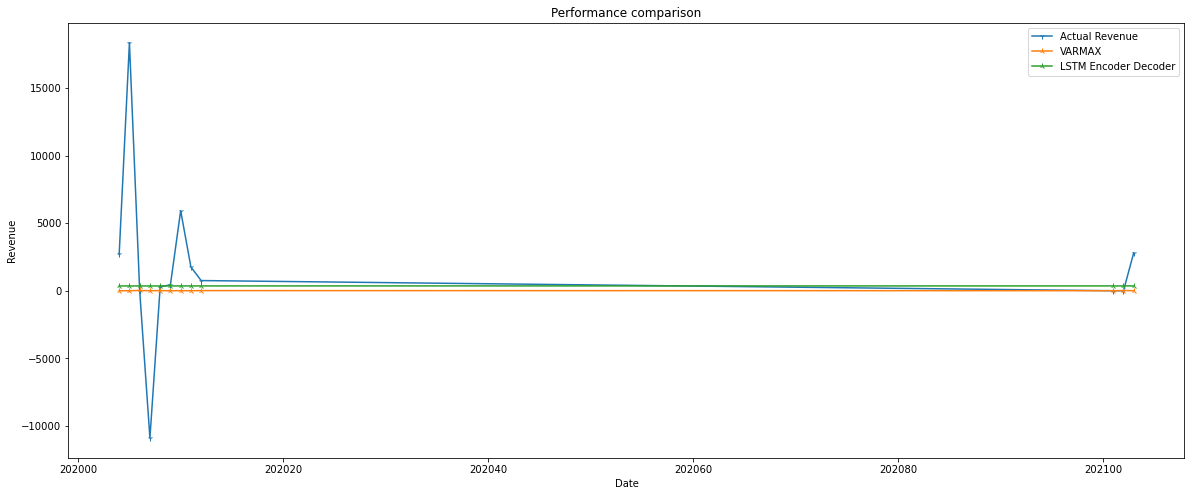

In [284]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(20, 8))
#plt.plot(timedf.index, timedf['Actual Net Revenue - MTD'], 'b-', label = 'Actual Revenue')
plt.plot(dates, actual, '1-', label = 'Actual Revenue') #b
plt.plot(dates, predictionvarmax1, '2-', label = 'VARMAX') 
plt.plot(dates, predictionlstm1, '2-', label = 'LSTM Encoder Decoder') 



plt.xlabel('Date'); plt.ylabel('Revenue'); plt.title('Performance comparison')
plt.legend();
plt.show()